In [1]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!cp -av 'drive/MyDrive/CV/final_project/data_pure.zip' './' 
!unzip -u -q "data_pure.zip"

'drive/MyDrive/CV/final_project/data_pure.zip' -> './data_pure.zip'


In [78]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import tensorflow.keras.layers as L
from tensorflow.keras.losses import MeanAbsoluteError

seed = 1
base_dir = './'
image_size=224

df = pd.read_csv(base_dir+"data/train.csv")
df['filename'] = df.apply(lambda row: row['id']+'.jpg',axis=1)

def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    #img = (img - 0.5) * 2
    return img

data_gen_args = dict(preprocessing_function=prep_fn,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.1,
                     rotation_range=20,
                     horizontal_flip=False,
                     vertical_flip=False,
                     validation_split=0.1)

train_datagen = ImageDataGenerator(**data_gen_args)
val_datagen = ImageDataGenerator(preprocessing_function=prep_fn,validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                    directory=base_dir+'data/train/',
                                                    x_col='filename',
                                                    y_col=['x','y'],
                                                    subset="training",
                                                    batch_size = 32,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    target_size=(224,224))
val_generator = val_datagen.flow_from_dataframe(dataframe=df,
                                                directory=base_dir+'data/train/',
                                                x_col='filename',
                                                y_col=['x','y'],
                                                subset="validation",
                                                batch_size = 32,
                                                seed=seed,
                                                shuffle=True,
                                                class_mode='raw',
                                                target_size=(224,224))

Found 7500 validated image filenames.
Found 750 validated image filenames.


In [79]:
df_test = pd.read_csv("data/imagenames.csv")
df_test['filename'] = df_test.apply(lambda row: row['id']+'.jpg',axis=1)
df_test['x']=0
df_test['y']=0
test_datagen = ImageDataGenerator(preprocessing_function=prep_fn)
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory=base_dir+'data/test/',
                                                x_col='filename',
                                                y_col=['x','y'],
                                                batch_size = 32,
                                                shuffle=False,
                                                class_mode='raw',
                                                target_size=(224,224))

Found 1200 validated image filenames.


In [18]:
patch_size=7
num_patches = (image_size//patch_size) **2
projection_dim = 32
num_heads = 3
transformer_units = [projection_dim*2, projection_dim]
transformer_layers = 3
mlp_head_units = [1024,128]

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [8]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


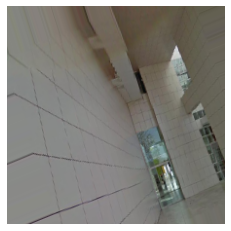

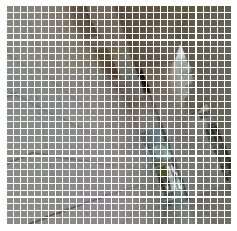

In [9]:
plt.figure(figsize=(4, 4))

x = train_generator.next()
image = x[0][0]

plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')

In [91]:
from tensorflow.keras.optimizers import Adam

In [11]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [39]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0)
    
    # Classify outputs.
    out = L.Dense(2)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = out)
    
    return model

In [92]:
model = vision_transformer()
model.compile(optimizer = Adam(learning_rate=0.001), 
              loss=MeanAbsoluteError())

In [66]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
patches_12 (Patches)            (None, None, 147)    0           input_12[0][0]                   
__________________________________________________________________________________________________
patch_encoder_11 (PatchEncoder) (None, 1024, 32)     37504       patches_12[0][0]                 
__________________________________________________________________________________________________
layer_normalization_77 (LayerNo (None, 1024, 32)     64          patch_encoder_11[0][0]           
___________________________________________________________________________________________

In [93]:
with tf.device('/device:GPU:0'):
    model.load_weights("drive/MyDrive/CV/Model/vit_all")
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    r=model.fit(train_generator, validation_data=val_generator,
                validation_steps=20,steps_per_epoch=211,epochs=20,callbacks=[callback])

Epoch 1/20
235/235 [==============================] - 137s 565ms/step - loss: 7.0310 - val_loss: 7.5232
Epoch 2/20
235/235 [==============================] - 132s 562ms/step - loss: 6.9950 - val_loss: 6.7315
Epoch 3/20
235/235 [==============================] - 134s 569ms/step - loss: 6.8004 - val_loss: 6.7053
Epoch 4/20
235/235 [==============================] - 135s 573ms/step - loss: 6.7387 - val_loss: 6.5342
Epoch 5/20
235/235 [==============================] - 136s 577ms/step - loss: 7.1446 - val_loss: 6.4180
Epoch 6/20
235/235 [==============================] - 132s 561ms/step - loss: 6.9356 - val_loss: 6.2772
Epoch 7/20
235/235 [==============================] - 132s 563ms/step - loss: 6.9941 - val_loss: 6.8947
Epoch 8/20
235/235 [==============================] - 131s 558ms/step - loss: 6.6034 - val_loss: 6.8783


In [94]:
model.save_weights("drive/MyDrive/CV/Model/vit_all")

In [95]:
with tf.device('/device:GPU:0'):
    ypred = model.predict(test_generator)
ypred.shape

(1200, 2)

In [96]:
df_test['x'] = ypred[:,0]
df_test['y'] = ypred[:,1]
if 'filename' in df_test.keys():
    df_test=df_test.drop(columns=['filename'])
df_test.head()
df_test.to_csv('pred_vit.csv',index=False)